
3D MRI Super Resolution
==============
Author: Huixiang Zhuang




In [1]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import random
import time
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
import pandas as pd
from IPython.display import HTML
plt.ion()   # interactive mode

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
# from torch.optim import lr_scheduler


# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Input

**Parameter setting**

Here we define some inputs for the run:

-  **vm_PATH** - the path of folder in your local machine that mounts google storage 
-  **id_csv** - the path to the .csv file that has id of subjects
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size here in fact determine the number of samples once download. We uses a batch size of 2
-  **patch_size** - the patch size here in fact determine the number of images (cubes) as the input in one training. We uses a patch size of 2 as is recommended in the paper
-  **cube_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **usage** - the usage of a patch cluster. usage < 1.0 would mean we choose to randomly give up some patches by this probability
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [2]:
# Set pathes
vm_PATH = "./mnt/superresolution/HCP_1200/"
id_csv = './csv/id_hcp.csv'

# Number of workers for dataloader
workers = 1

# Batch size. It controls the number of samples once download
batch_size = 16

# Patch size, it controls the number of patches once send into the model
patch_size = 4

# The size of one image patch (eg. 64 means a cubic patch with size: 64x64x64)
cube_size = 64

# Set the usage of a patch cluster.
usage = 1.0

# Number of training steps (1.05e6)
num_steps = 1000000

# Number of mDCSRN (G) pre-training steps (5e5)
num_steps_pre = 250000

# Number of imbalanced training (7D vs 1G) steps
num_steps_imbal = 10000


# Learning rate for mDCSRN (G) pre-training optimizers (in paper: 1e-4)
lr_pre = 1e-4

# Learning rate for optimizers (in paper: 5e-6)
lr = 5e-6

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

# Set percentage of data spliting
train_split= 0.7
validate_split = 0.1
evaluate_split = 0.1
test_split = 0.1

# Set shuffle and stablize random_seed
shuffle_dataset = True
random_seed= 999

# set GPU device
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Data loading with online fetching, and patching



In [3]:
from ecbm6040.dataloader.CustomDatasetFromCSV import CustomDatasetFromCSV

from ecbm6040.patching.patchloader import patching

**Split data, create dataloaders**

In [4]:
# load data from csv
dataset = CustomDatasetFromCSV(id_csv,vm_PATH)
dataset_size = len(dataset)

# get indices for spliting train, valiadate, evaluate, test sets
train_size = math.ceil(train_split * dataset_size)
validate_size = int(validate_split * dataset_size)
evaluate_size = int(evaluate_split * dataset_size)
test_size = int(dataset_size - train_size - validate_size - evaluate_size)

indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices = indices[:train_size]
loc_val = train_size + validate_size
val_indices = indices[train_size:loc_val]
loc_eval = loc_val + evaluate_size
eval_indices = indices[loc_val:loc_eval]
test_indices = indices[loc_eval:]
num_train = len(train_indices)
num_val = len(val_indices)
num_eval = len(eval_indices)
num_test = len(test_indices)
print('training set number:{}'.format(len(train_indices)))
print('validation set number:{}'.format(len(val_indices)))
print('evaluation set number:{}'.format(len(eval_indices)))
print('test set number:{}'.format(len(test_indices)))

training set number:780
validation set number:111
evaluation set number:111
test set number:111


In [5]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
eval_sampler = SubsetRandomSampler(eval_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=train_sampler,
                                        shuffle=False,
                                        num_workers=workers)
validation_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=valid_sampler,
                                        shuffle=False,
                                        num_workers=workers)
eval_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=eval_sampler,
                                        shuffle=False,
                                        num_workers=workers)
test_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=test_sampler,
                                        shuffle=False,
                                        num_workers=workers)


dataloaders={'train':train_loader, 'val':validation_loader}
dataset_sizes={'train':len(train_sampler), 'val':len(valid_sampler)}

# Implementation
We will start with the weight initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.



**Weight Initialization**



In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Generator**

In [7]:
from ecbm6040.model.mDCSRN_WGAN import Generator

# Create the generator
netG = Generator(ngpu).cuda(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netG.apply(weights_init)

# Print the model
print(netG)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))

DataParallel(
  (module): Generator(
    (conv0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (block0): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace)
        (conv): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace)
        (conv): Conv3d(48, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer3): _DenseLayer(
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace)
        (conv): Conv3d(64, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
     

**Discriminator**



In [8]:
from ecbm6040.model.mDCSRN_WGAN import Discriminator

# Create the Discriminator
netD = Discriminator(ngpu).cuda(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): LayerNorm(torch.Size([64, 32, 32, 32]), eps=1e-05, elementwise_affine=True)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (6): LayerNorm(torch.Size([128, 32, 32, 32]), eps=1e-05, elementwise_affine=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (9): LayerNorm(torch.Size([128, 16, 16, 16]), eps=1e-05, elementwise_affine=True)
      (10): LeakyReLU(negative_slope=0.2)
      (11): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (12): LayerNorm(torch.Size([256, 16, 16, 16]), eps=1e-05, elementw

In [9]:
# Initialize Loss functions
supervised_criterion = nn.L1Loss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)

Training
~~~~~~~~

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in `ganhacks <https://github.com/soumith/ganhacks>`__.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.




In [10]:
from training_pre import training_pre

In [11]:
model=training_pre(netG, dataloaders, 
                   dataset_sizes, supervised_criterion, 
                   device, ngpu, max_step=num_steps_pre, 
                   lr=lr_pre, patch_size=patch_size, pretrained='models/pretrained_G_step225000')

Generator pre-training...
Step 100000/250000
----------
Step: 105000, loss= 0.0165
Step: 110000, loss= 0.0194
Step: 115000, loss= 0.0347
train Loss: 1.6953
val Loss: 1.7552
Now the training uses 305m 9s

Step 119500/250000
----------
Step: 120000, loss= 0.0094
Step: 125000, loss= 0.0086
Step: 130000, loss= 0.0152
Step: 135000, loss= 0.0166
train Loss: 1.6946
val Loss: 1.7548
Now the training uses 610m 29s

Step 139000/250000
----------
Step: 140000, loss= 0.0306
Step: 145000, loss= 0.0196
Step: 150000, loss= 0.0136
Step: 155000, loss= 0.0159
train Loss: 1.6954
val Loss: 1.7695
Now the training uses 915m 49s

Step 158500/250000
----------
Step: 160000, loss= 0.0146
Step: 165000, loss= 0.0143
Step: 170000, loss= 0.0162
Step: 175000, loss= 0.0138
train Loss: 1.6954
val Loss: 1.7607
Now the training uses 1221m 7s

Step 178000/250000
----------
Step: 180000, loss= 0.0121
Step: 185000, loss= 0.0210
Step: 190000, loss= 0.0158
Step: 195000, loss= 0.0221
train Loss: 1.6964
val Loss: 1.7768
Now 

In [12]:
def check_result_images(step,slice=50):
    f=open('example_images/example_lr_step{}.txt'.format(step),'rb')
    lr_patches = pickle.load(f)
    f.close()
    f=open('example_images/example_sr_step{}.txt'.format(step),'rb')
    sr_patches = pickle.load(f)
    f.close()
    f=open('example_images/example_hr_step{}.txt'.format(step),'rb')
    hr_patches = pickle.load(f)
    f.close()
    f = plt.figure(figsize=(16,8))
    patch_size = lr_patches.shape[0]
    for patch in range(patch_size):
        sp = f.add_subplot(patch_size,3,patch*3+1)
        sp.axis('Off')
        sp.set_title('Low resolution image', fontsize=16)
        plt.imshow(lr_patches[patch,0,slice,:,:],cmap='gray')
        
        sp = f.add_subplot(patch_size,3,patch*3+2)
        sp.axis('Off')
        sp.set_title('Super resolution image', fontsize=16)
        plt.imshow(sr_patches[patch,0,slice,:,:],cmap='gray')
        
        sp = f.add_subplot(patch_size,3,patch*3+3)
        sp.axis('Off')
        sp.set_title('High resolution image', fontsize=16)
        plt.imshow(hr_patches[patch,0,slice,:,:],cmap='gray')


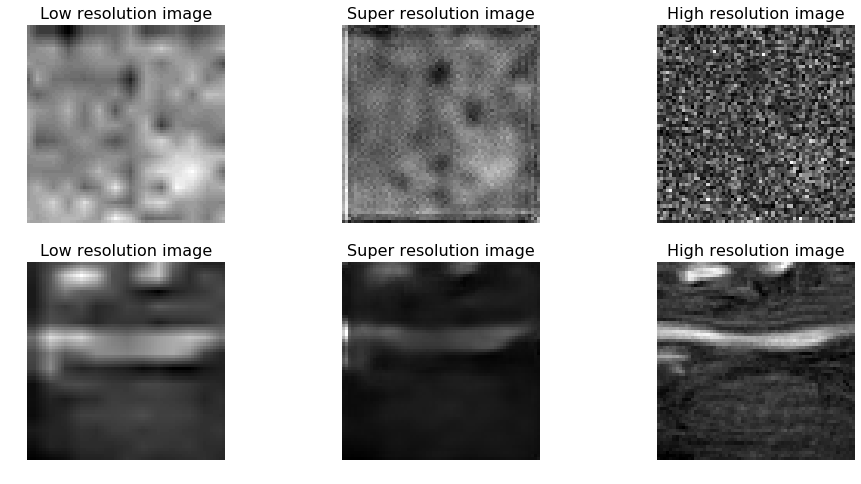

In [13]:
check_result_images(step=250000,slice=40)